In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import gc

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
#
def autocorrelation(ys, t=1):
    return np.corrcoef(ys[:-t], ys[t:])

In [3]:
sales = pd.read_csv("../input/walmartadd1/walmart-add/sales.csv")
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,start,scale
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,3,3,0,1,901,0.773603
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,0,0,0,0,143,0.422049
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,0,0,0,2,3,0,1,1105,0.511990
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,4,0,1,3,0,2,6,36,1.778245
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,2,1,0,0,2,1,0,112,1.102354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42835,WI_3_X,X,X,X,WI_3,WI,4038,4198,3317,3211,...,5894,3897,3306,3268,3398,4126,4519,4757,0,538.851470
42836,CA_X,X,X,X,CA,CA,14195,13805,10108,11047,...,24704,17721,16150,15678,16297,17430,23103,24644,0,1970.131511
42837,TX_X,X,X,X,TX,TX,9438,9630,6778,7381,...,16249,12228,11370,10375,9162,12303,13681,14815,0,1349.161939
42838,WI_X,X,X,X,WI,WI,8998,8314,6897,6984,...,18968,12413,11257,11043,11504,12819,14734,14879,0,1440.429603


In [4]:
#==========================================================================
def preprocess_sales(sales, start=1400, upper=1970):
    if start is not None:
        print("dropping...")
        to_drop = [f"d_{i+1}" for i in range(start-1)]
        print(sales.shape)
        sales.drop(to_drop, axis=1, inplace=True)
        print(sales.shape)
    #=======
    print("adding...")
    new_columns = ['d_%i'%i for i in range(1942, upper, 1)]
    for col in new_columns:
        sales[col] = np.nan
    print("melting...")
    sales = sales.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id","scale","start"],
                        var_name='d', value_name='demand')

    print("generating order")
    if start is not None:
        skip = start
    else:
        skip = 1
    sales["nb"] =sales.index // 42840 + skip
    return sales
#===============================================================
def preprocess_calendar(calendar):
    global maps, mods
    calendar["event_name"] = calendar["event_name_1"]
    calendar["event_type"] = calendar["event_type_1"]

    map1 = {mod:i for i,mod in enumerate(calendar['event_name'].unique())}
    calendar['event_name'] = calendar['event_name'].map(map1)
    map2 = {mod:i for i,mod in enumerate(calendar['event_type'].unique())}
    calendar['event_type'] = calendar['event_type'].map(map2)
    calendar['nday'] = calendar['date'].str[-2:].astype(int)
    maps["event_name"] = map1
    maps["event_type"] = map2
    mods["event_name"] = len(map1)
    mods["event_type"] = len(map2)
    calendar["wday"] -=1
    calendar["month"] -=1
    calendar["year"] -= 2011
    mods["month"] = 12
    mods["year"] = 6
    mods["wday"] = 7
    mods['snap_CA'] = 2
    mods['snap_TX'] = 2
    mods['snap_WI'] = 2

    calendar.drop(["event_name_1", "event_name_2", "event_type_1", "event_type_2", "date", "weekday"], 
                  axis=1, inplace=True)
    return calendar
#=========================================================
def make_dataset(categorize=False ,start=1400, upper= 1970):
    global maps, mods
    print("loading calendar...")
    calendar = pd.read_csv("../input/m5-forecasting-uncertainty/calendar.csv")
    print("loading sales...")
    sales = pd.read_csv("../input/walmartadd1/walmart-add/sales.csv")
    cols = ["item_id", "dept_id", "cat_id","store_id","state_id"]
    if categorize:
        for col in cols:
            temp_dct = {mod:i for i, mod in enumerate(sales[col].unique())}
            mods[col] = len(temp_dct)
            maps[col] = temp_dct
        for col in cols:
            sales[col] = sales[col].map(maps[col])
        #

    sales =preprocess_sales(sales, start=start, upper= upper)
    calendar = preprocess_calendar(calendar)
    calendar = reduce_mem_usage(calendar)
    print("merge with calendar...")
    sales = sales.merge(calendar, on='d', how='left')
    del calendar

    print("reordering...")
    sales.sort_values(by=["id","nb"], inplace=True)
    print("re-indexing..")
    sales.reset_index(inplace=True, drop=True)
    gc.collect()

    sales['n_week'] = (sales['nb']-1)//7
    sales["nday"] -= 1
    mods['nday'] = 31
    sales = reduce_mem_usage(sales)
    gc.collect()
    return sales
#===============================================================================#

In [5]:
%%time
CATEGORIZE = True;
START = 1400; UPPER = 1970;
maps = {}
mods = {}
sales = make_dataset(categorize=CATEGORIZE ,start=START, upper= UPPER)

loading calendar...
loading sales...
dropping...
(42840, 1949)
(42840, 550)
adding...
melting...
generating order
Mem. usage decreased to  0.04 Mb (78.4% reduction)
merge with calendar...
reordering...
re-indexing..
Mem. usage decreased to 1001.37 Mb (59.8% reduction)
CPU times: user 32.9 s, sys: 8.37 s, total: 41.3 s
Wall time: 41.2 s


In [6]:
sales.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'scale',
       'start', 'd', 'demand', 'nb', 'wm_yr_wk', 'wday', 'month', 'year',
       'snap_CA', 'snap_TX', 'snap_WI', 'event_name', 'event_type', 'nday',
       'n_week'],
      dtype='object')

In [7]:
sales["x"] = sales["demand"] / sales["scale"]

In [8]:
LAGS = [28, 35, 42, 49, 56, 63]
FEATS = []
for lag in tqdm(LAGS):
    sales[f"x_{lag}"] = sales.groupby("id")["x"].shift(lag)
    FEATS.append(f"x_{lag}")
#

100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


In [9]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,scale,start,d,demand,...,event_type,nday,n_week,x,x_28,x_35,x_42,x_49,x_56,x_63
0,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1400,2296.0,...,0,27,199,4.929688,NaN,NaN,NaN,NaN,NaN,NaN
1,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1401,2984.0,...,0,28,200,6.406250,NaN,NaN,NaN,NaN,NaN,NaN
2,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1402,3228.0,...,0,29,200,6.929688,NaN,NaN,NaN,NaN,NaN,NaN
3,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1403,2868.0,...,0,0,200,6.156250,NaN,NaN,NaN,NaN,NaN,NaN
4,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1404,2312.0,...,0,1,200,4.964844,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24418795,WI_X,3059,11,3,12,2,1440.00,0,d_1965,NaN,...,0,14,280,NaN,7.667969,10.242188,8.625000,6.964844,7.355469,7.562500
24418796,WI_X,3059,11,3,12,2,1440.00,0,d_1966,NaN,...,0,15,280,NaN,7.988281,9.382812,9.539062,7.234375,7.601562,8.453125
24418797,WI_X,3059,11,3,12,2,1440.00,0,d_1967,NaN,...,0,16,280,NaN,8.898438,9.218750,9.992188,9.414062,8.890625,10.234375
24418798,WI_X,3059,11,3,12,2,1440.00,0,d_1968,NaN,...,0,17,281,NaN,10.234375,13.132812,12.125000,10.703125,10.320312,10.648438


In [10]:
sales.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'scale',
       'start', 'd', 'demand', 'nb', 'wm_yr_wk', 'wday', 'month', 'year',
       'snap_CA', 'snap_TX', 'snap_WI', 'event_name', 'event_type', 'nday',
       'n_week', 'x', 'x_28', 'x_35', 'x_42', 'x_49', 'x_56', 'x_63'],
      dtype='object')

In [11]:
#sales.loc[(sales.start>1844)&(sales.nb>1840)&(sales.nb<1850), ['id','start','nb','demand']]
#sales.start.max() #1845

In [12]:
print(sales.shape)
sales = sales.loc[sales.nb>sales.start]
print(sales.shape)

(24418800, 29)
(24268220, 29)


In [13]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,scale,start,d,demand,...,event_type,nday,n_week,x,x_28,x_35,x_42,x_49,x_56,x_63
0,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1400,2296.0,...,0,27,199,4.929688,NaN,NaN,NaN,NaN,NaN,NaN
1,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1401,2984.0,...,0,28,200,6.406250,NaN,NaN,NaN,NaN,NaN,NaN
2,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1402,3228.0,...,0,29,200,6.929688,NaN,NaN,NaN,NaN,NaN,NaN
3,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1403,2868.0,...,0,0,200,6.156250,NaN,NaN,NaN,NaN,NaN,NaN
4,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1404,2312.0,...,0,1,200,4.964844,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24418795,WI_X,3059,11,3,12,2,1440.00,0,d_1965,NaN,...,0,14,280,NaN,7.667969,10.242188,8.625000,6.964844,7.355469,7.562500
24418796,WI_X,3059,11,3,12,2,1440.00,0,d_1966,NaN,...,0,15,280,NaN,7.988281,9.382812,9.539062,7.234375,7.601562,8.453125
24418797,WI_X,3059,11,3,12,2,1440.00,0,d_1967,NaN,...,0,16,280,NaN,8.898438,9.218750,9.992188,9.414062,8.890625,10.234375
24418798,WI_X,3059,11,3,12,2,1440.00,0,d_1968,NaN,...,0,17,281,NaN,10.234375,13.132812,12.125000,10.703125,10.320312,10.648438


In [14]:
sales['nb'].values

array([1400, 1401, 1402, ..., 1967, 1968, 1969], dtype=int16)

In [15]:
sales.index

Int64Index([       0,        1,        2,        3,        4,        5,
                   6,        7,        8,        9,
            ...
            24418790, 24418791, 24418792, 24418793, 24418794, 24418795,
            24418796, 24418797, 24418798, 24418799],
           dtype='int64', length=24268220)

In [16]:
nb = sales['nb'].values
MAX_LAG = max(LAGS)
#tr_mask = np.logical_and(nb>START + MAX_LAG, nb<=1913)
tr_mask = np.logical_and(nb>START + MAX_LAG, nb<=1941) # SORRY THIS IS FAKE VALIDATION. I DIDN'T THINK IT WOULD HAVE HAD LIFTED UP MY SCORE LIKE THAT
val_mask = np.logical_and(nb>1913, nb<=1941)
te_mask = np.logical_and(nb>1941, nb<=1969)

In [17]:
print(tr_mask.shape)
print(val_mask.shape)
print(te_mask.shape)

(24268220,)
(24268220,)
(24268220,)


In [18]:
scale = sales['scale'].values
ids = sales['id'].values
#y = sales['demand'].values
#ys = y / scale
ys = sales['x'].values
Z = sales[FEATS].values

In [19]:
sv = scale[val_mask]
se = scale[te_mask]
ids = ids[te_mask]
ids = ids.reshape((-1, 28))

In [20]:
sv.shape

(1199520,)

In [21]:
se.shape

(1199520,)

In [22]:
ids

array([['CA_1_FOODS', 'CA_1_FOODS', 'CA_1_FOODS', ..., 'CA_1_FOODS',
        'CA_1_FOODS', 'CA_1_FOODS'],
       ['CA_1_FOODS_1', 'CA_1_FOODS_1', 'CA_1_FOODS_1', ...,
        'CA_1_FOODS_1', 'CA_1_FOODS_1', 'CA_1_FOODS_1'],
       ['CA_1_FOODS_2', 'CA_1_FOODS_2', 'CA_1_FOODS_2', ...,
        'CA_1_FOODS_2', 'CA_1_FOODS_2', 'CA_1_FOODS_2'],
       ...,
       ['WI_HOUSEHOLD_2_515', 'WI_HOUSEHOLD_2_515', 'WI_HOUSEHOLD_2_515',
        ..., 'WI_HOUSEHOLD_2_515', 'WI_HOUSEHOLD_2_515',
        'WI_HOUSEHOLD_2_515'],
       ['WI_HOUSEHOLD_2_516', 'WI_HOUSEHOLD_2_516', 'WI_HOUSEHOLD_2_516',
        ..., 'WI_HOUSEHOLD_2_516', 'WI_HOUSEHOLD_2_516',
        'WI_HOUSEHOLD_2_516'],
       ['WI_X', 'WI_X', 'WI_X', ..., 'WI_X', 'WI_X', 'WI_X']],
      dtype=object)

In [23]:
ca = sales[['snap_CA']].values
tx = sales[['snap_TX']].values
wi = sales[['snap_WI']].values
wday = sales[['wday']].values
month = sales[['month']].values
year = sales[['year']].values
event = sales[['event_name']].values
nday = sales[['nday']].values

In [24]:
item = sales[['item_id']].values
dept = sales[['dept_id']].values
cat = sales[['cat_id']].values
store = sales[['store_id']].values
state = sales[['state_id']].values

In [25]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,scale,start,d,demand,...,event_type,nday,n_week,x,x_28,x_35,x_42,x_49,x_56,x_63
0,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1400,2296.0,...,0,27,199,4.929688,NaN,NaN,NaN,NaN,NaN,NaN
1,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1401,2984.0,...,0,28,200,6.406250,NaN,NaN,NaN,NaN,NaN,NaN
2,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1402,3228.0,...,0,29,200,6.929688,NaN,NaN,NaN,NaN,NaN,NaN
3,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1403,2868.0,...,0,0,200,6.156250,NaN,NaN,NaN,NaN,NaN,NaN
4,CA_1_FOODS,3056,7,2,0,0,465.75,0,d_1404,2312.0,...,0,1,200,4.964844,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24418795,WI_X,3059,11,3,12,2,1440.00,0,d_1965,NaN,...,0,14,280,NaN,7.667969,10.242188,8.625000,6.964844,7.355469,7.562500
24418796,WI_X,3059,11,3,12,2,1440.00,0,d_1966,NaN,...,0,15,280,NaN,7.988281,9.382812,9.539062,7.234375,7.601562,8.453125
24418797,WI_X,3059,11,3,12,2,1440.00,0,d_1967,NaN,...,0,16,280,NaN,8.898438,9.218750,9.992188,9.414062,8.890625,10.234375
24418798,WI_X,3059,11,3,12,2,1440.00,0,d_1968,NaN,...,0,17,281,NaN,10.234375,13.132812,12.125000,10.703125,10.320312,10.648438


In [26]:
def make_data(mask):
    x = {"snap_CA":ca[mask], "snap_TX":tx[mask], "snap_WI":wi[mask], "wday":wday[mask], 
         "month":month[mask], "year":year[mask], "event":event[mask], "nday":nday[mask], 
         "item":item[mask], "dept":dept[mask], "cat":cat[mask], "store":store[mask], 
         "state":state[mask], "num":Z[mask]}
    t = ys[mask]
    return x, t

In [27]:
xt, yt = make_data(tr_mask) #train
xv, yv = make_data(val_mask) # val
xe, ye = make_data(te_mask) # test

In [28]:
xt, yt

({'snap_CA': array([[0],
         [1],
         [1],
         ...,
         [0],
         [0],
         [0]], dtype=int8),
  'snap_TX': array([[0],
         [1],
         [0],
         ...,
         [0],
         [0],
         [0]], dtype=int8),
  'snap_WI': array([[0],
         [0],
         [1],
         ...,
         [0],
         [0],
         [0]], dtype=int8),
  'wday': array([[0],
         [1],
         [2],
         ...,
         [6],
         [0],
         [1]], dtype=int8),
  'month': array([[0],
         [1],
         [1],
         ...,
         [4],
         [4],
         [4]], dtype=int8),
  'year': array([[4],
         [4],
         [4],
         ...,
         [5],
         [5],
         [5]], dtype=int8),
  'event': array([[0],
         [1],
         [0],
         ...,
         [0],
         [0],
         [0]], dtype=int8),
  'nday': array([[30],
         [ 0],
         [ 1],
         ...,
         [19],
         [20],
         [21]], dtype=int8),
  'item': array([[3056]

In [29]:
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

## It is a baseline model. Feel free to add your own FE magic !!!

In [30]:

#=====
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#============================#
def make_model(n_in):
    
    num = L.Input((n_in,), name="num")
    
    ca = L.Input((1,), name="snap_CA")
    tx = L.Input((1,), name="snap_TX")
    wi = L.Input((1,), name="snap_WI")
    wday = L.Input((1,), name="wday")
    month = L.Input((1,), name="month")
    year = L.Input((1,), name="year")
    event = L.Input((1,), name="event")
    nday = L.Input((1,), name="nday")
    item = L.Input((1,), name="item")
    dept = L.Input((1,), name="dept")
    cat = L.Input((1,), name="cat")
    store = L.Input((1,), name="store")
    state = L.Input((1,), name="state")
    inp = {"snap_CA":ca, "snap_TX":tx, "snap_WI":wi, "wday":wday, 
           "month":month, "year":year, "event":event, "nday":nday,
           "item":item, "dept":dept, "cat":cat, "store":store, 
           "state":state, "num":num} 
    #
    ca_ = L.Embedding(mods["snap_CA"], mods["snap_CA"], name="ca_3d")(ca)
    tx_ = L.Embedding(mods["snap_TX"], mods["snap_TX"], name="tx_3d")(tx)
    wi_ = L.Embedding(mods["snap_WI"], mods["snap_WI"], name="wi_3d")(wi)
    wday_ = L.Embedding(mods["wday"], mods["wday"], name="wday_3d")(wday)
    month_ = L.Embedding(mods["month"], mods["month"], name="month_3d")(month)
    year_ = L.Embedding(mods["year"], mods["year"], name="year_3d")(year)
    event_ = L.Embedding(mods["event_name"], mods["event_name"], name="event_3d")(event)
    nday_ = L.Embedding(mods["nday"], mods["nday"], name="nday_3d")(nday)
    item_ = L.Embedding(mods["item_id"], 10, name="item_3d")(item)
    dept_ = L.Embedding(mods["dept_id"], mods["dept_id"], name="dept_3d")(dept)
    cat_ = L.Embedding(mods["cat_id"], mods["cat_id"], name="cat_3d")(cat)
    store_ = L.Embedding(mods["store_id"], mods["store_id"], name="store_3d")(store)
    state_ = L.Embedding(mods["state_id"], mods["state_id"], name="state_3d")(state)
    
    p = [ca_, tx_, wi_, wday_, month_, year_, event_, nday_, item_, dept_, cat_, store_, state_]
    emb = L.Concatenate(name="embds")(p)
    context = L.Flatten(name="context")(emb)
    
    x = L.Concatenate(name="x1")([context, num])
    x = L.Dense(500, activation="relu", name="d1")(x)
    x = L.Dropout(0.3)(x)
    x = L.Concatenate(name="m1")([x, context])
    x = L.Dense(500, activation="relu", name="d2")(x)
    x = L.Dropout(0.3)(x)
    x = L.Concatenate(name="m2")([x, context])
    x = L.Dense(500, activation="relu", name="d3")(x)
    preds = L.Dense(9, activation="linear", name="preds")(x)
    model = M.Model(inp, preds, name="M1")
    model.compile(loss=qloss, optimizer="adam")
    return model

In [31]:
net = make_model(len(FEATS))
ckpt = ModelCheckpoint("w.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
es = EarlyStopping(monitor='val_loss', patience=3)
print(net.summary())

Model: "M1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
snap_CA (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
snap_TX (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
snap_WI (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
wday (InputLayer)               [(None, 1)]          0                                            
_________________________________________________________________________________________________

In [32]:
net.fit(xt, yt, batch_size=50_000, epochs=20, validation_data=(xv, yv), callbacks=[ckpt, reduce_lr, es])

Train on 20394682 samples, validate on 1199520 samples
Epoch 1/20
20350000/20394682 [============================>.] - ETA: 0s - loss: 0.2116
Epoch 00001: val_loss improved from inf to 0.22784, saving model to w.h5
20394682/20394682 [==============================] - 50s 2us/sample - loss: 0.2116 - val_loss: 0.2278
Epoch 2/20
20350000/20394682 [============================>.] - ETA: 0s - loss: 0.2007
Epoch 00002: val_loss improved from 0.22784 to 0.22448, saving model to w.h5
20394682/20394682 [==============================] - 46s 2us/sample - loss: 0.2007 - val_loss: 0.2245
Epoch 3/20
20350000/20394682 [============================>.] - ETA: 0s - loss: 0.1981
Epoch 00003: val_loss improved from 0.22448 to 0.22238, saving model to w.h5
20394682/20394682 [==============================] - 46s 2us/sample - loss: 0.1981 - val_loss: 0.2224
Epoch 4/20
20350000/20394682 [============================>.] - ETA: 0s - loss: 0.1956
Epoch 00004: val_loss improved from 0.22238 to 0.21956, saving m

In [33]:
nett = make_model(len(FEATS))
nett.load_weights("w.h5")

In [34]:
pv = nett.predict(xv, batch_size=50_000, verbose=1)
pe = nett.predict(xe, batch_size=50_000, verbose=1)

1199520/1199520 [==============================] - 1s 1us/sample


In [35]:
nett.evaluate(xv, yv, batch_size=50_000)

1199520/1199520 [==============================] - 1s 1us/sample - loss: 0.2115


0.21147708769311774

In [36]:
pv = pv.reshape((-1, 28, 9))
pe = pe.reshape((-1, 28, 9))

In [37]:
sv = sv.reshape((-1, 28))
se = se.reshape((-1, 28))

In [38]:
Yv = yv.reshape((-1, 28))

FOODS_2_070_CA_2


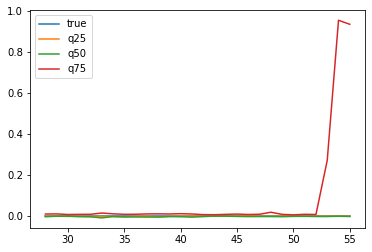

In [39]:
k = np.random.randint(0, 42840)
#k = np.random.randint(0, 200)
print(ids[k, 0])
plt.plot(np.arange(28, 56), Yv[k], label="true")
plt.plot(np.arange(28, 56), pv[k ,:, 3], label="q25")
plt.plot(np.arange(28, 56), pv[k ,:, 4], label="q50")
plt.plot(np.arange(28, 56), pv[k, :, 5], label="q75")
plt.legend(loc="best")
plt.show()

### Prediction

In [40]:
names = [f"F{i+1}" for i in range(28)]

In [41]:
piv = pd.DataFrame(ids[:, 0], columns=["id"])

In [42]:
QUANTILES = ["0.005", "0.025", "0.165", "0.250", "0.500", "0.750", "0.835", "0.975", "0.995"]
VALID = []
EVAL = []

for i, quantile in tqdm(enumerate(QUANTILES)):
    t1 = pd.DataFrame(pv[:,:, i]*sv, columns=names)
    t1 = piv.join(t1)
    t1["id"] = t1["id"] + f"_{quantile}_validation"
    t2 = pd.DataFrame(pe[:,:, i]*se, columns=names)
    t2 = piv.join(t2)
    t2["id"] = t2["id"] + f"_{quantile}_evaluation"
    VALID.append(t1)
    EVAL.append(t2)
#============#

9it [00:00, 25.08it/s]


In [43]:
sub = pd.DataFrame()
sub = sub.append(VALID + EVAL)
del VALID, EVAL, t1, t2

In [44]:
sub.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,CA_1_FOODS_0.005_validation,2288.487549,2194.388672,2001.047241,1995.388062,2392.582520,2769.726807,2917.460205,2478.817383,2260.357178,...,2377.943848,2917.724365,3201.941162,2511.985352,2196.520996,2123.770996,2089.363281,2308.277344,2841.734619,3149.451172
1,CA_1_FOODS_1_0.005_validation,182.740753,167.848511,153.892410,163.466476,204.604599,228.515045,213.507904,180.456314,181.100342,...,218.055634,253.452728,235.477219,191.964127,181.899704,180.036545,190.201141,205.964676,248.957367,238.250565
2,CA_1_FOODS_2_0.005_validation,337.598694,307.179749,248.412277,254.816528,315.053619,366.615448,382.956726,393.193451,361.553528,...,324.443634,409.043579,469.552521,379.079681,305.316895,291.258118,257.002258,304.617004,366.870392,428.631317
3,CA_1_FOODS_3_0.005_validation,1518.197021,1437.794800,1292.905396,1300.681641,1580.013306,1852.611694,1965.821045,1603.073853,1444.390747,...,1547.707153,2005.092529,2243.467529,1606.448608,1403.738892,1376.815430,1335.349609,1507.820801,1957.819580,2181.200684
4,CA_1_HOBBIES_0.005_validation,333.873291,309.192566,287.220367,285.107361,330.542847,380.913818,398.776154,336.682892,354.734528,...,339.506744,405.951721,410.075623,351.961761,324.281036,306.606140,305.422455,340.268555,403.867462,426.162689


In [45]:
sub.shape

(771120, 29)

In [46]:
sub.to_csv("submission.csv", index=False)